In [3]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib
import matplotlib.pyplot as pl
from umap import UMAP
import sklearn
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from COSMOS import cosmos
from COSMOS.pyWNN import pyWNN 

random_seed = 20

## Generating synthetic spatially resolved paired multi-omics data

### Importing the spatially resolved omics data

In [13]:
# Importing mouse visual cortex STARMap data
df_data = pd.read_csv('./MVC_counts.csv',sep=",",header=0,na_filter=False,index_col=0) 
df_meta = pd.read_csv('./MVC_meta.csv',sep=",",header=0,na_filter=False,index_col=0) 
df_pixels = df_meta.iloc[:,2:4]
df_labels = list(df_meta.iloc[:,1])
adata = sc.AnnData(X = df_data)
adata.obs['LayerName'] = df_labels
adata.obs['LayerName_2'] = list(df_meta.iloc[:,4])

# Spatial positions
adata.obsm['spatial'] = np.array(df_pixels)
adata.obs['x_pos'] = adata.obsm['spatial'][:,0]
adata.obs['y_pos'] = adata.obsm['spatial'][:,1]
label_type = ['L1','L2/3','L4','L5','L6','HPC/CC']

### Generating synthetic spatially resolved paired multi-omics data

In [3]:
# Shuffling L4/L5 and L5/L6 of the original data, respectively.
index_all = [np.array([i for i in range(len(df_labels)) if df_labels[i] == label_type[0]])]
for k in range(1,len(label_type)):
    temp_idx = np.array([i for i in range(len(df_labels)) if df_labels[i] == label_type[k]])
    index_all.append(temp_idx)
index_int1 = np.array(list(index_all[2]) + list(index_all[3]))
index_int2 = np.array(list(index_all[4]) + list(index_all[3]))

# Adding Gaussian noise to each omics
adata2 = adata.copy()
np.random.seed(random_seed)
data_noise_1 = 1 + np.random.normal(0,0.05,adata.shape)
adata2.X[index_int1,:] = np.multiply(adata.X,data_noise_1)[np.random.permutation(index_int1),:]

adata3 = adata.copy()
np.random.seed(random_seed+1)
data_noise_2 = 1 + np.random.normal(0,0.05,adata.shape)
adata3.X[index_int2,:] = np.multiply(adata.X,data_noise_2)[np.random.permutation(index_int2),:]

## Applying COSMOS to integrate two omics

In [4]:
# COSMOS integration
cosmos_ebdg = cosmos.Cosmos(adata1=adata2,adata2=adata3)
cosmos_ebdg.preprocessing_data(n_neighbors = 10)
cosmos_ebdg.train(spatial_regularization_strength=0.05, z_dim=50, 
         lr=1e-3, wnn_iter = 200, epochs=1000, max_patience=30, min_stop=200, 
         random_seed=random_seed, gpu=0, regularization_acceleration=True, edge_subset_sz=1000000)

Epoch 1/1000, Loss: 1.407304048538208
Epoch 11/1000, Loss: 1.3828279972076416
Epoch 21/1000, Loss: 1.2418879270553589
Epoch 31/1000, Loss: 0.9489690661430359
Epoch 41/1000, Loss: 0.5506145358085632
Epoch 51/1000, Loss: 0.2985351085662842
Epoch 61/1000, Loss: 0.14992496371269226
Epoch 71/1000, Loss: 0.09670949727296829
Epoch 81/1000, Loss: 0.08348587900400162
Epoch 91/1000, Loss: 0.06673721224069595
Epoch 101/1000, Loss: 0.06292645633220673
Epoch 111/1000, Loss: 0.05204888805747032
Epoch 121/1000, Loss: 0.05640723928809166
Epoch 131/1000, Loss: 0.06786252558231354
Epoch 141/1000, Loss: 0.043121907860040665
Epoch 151/1000, Loss: 0.05887128412723541
Epoch 161/1000, Loss: 0.039696577936410904
Epoch 171/1000, Loss: 0.05698337033390999
Epoch 181/1000, Loss: 0.04013054817914963
Epoch 191/1000, Loss: 0.03397485613822937
Computing KNN distance matrices using default Scanpy implementation
Computing modality weights
Computing weighted distances for union of 200 nearest neighbors between modalitie

array([[-0.05493987,  0.15284388,  0.07075815, ...,  0.04809655,
         0.00620506, -0.07365942],
       [ 0.08108898,  0.17517903,  0.00076675, ...,  0.17717457,
        -0.01891655,  0.08888168],
       [-0.01480036,  0.19822043, -0.01967997, ...,  0.16679606,
        -0.03331025,  0.25963998],
       ...,
       [-0.00753601,  0.03733094,  0.03559036, ...,  0.24567398,
         0.01635138, -0.01514187],
       [-0.04737057,  0.10044597, -0.04291066, ..., -0.08256565,
        -0.01692639,  0.19435354],
       [ 0.08286243,  0.07818733, -0.00067401, ...,  0.04567537,
         0.01922617,  0.16130477]], dtype=float32)

### Showing modality weights of two omics in COSMOS

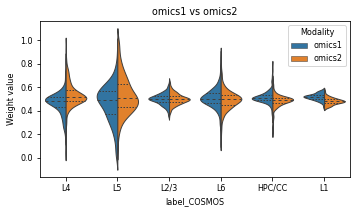

In [7]:
def plot_weight_value(alpha, label, modality1='omics1', modality2='omics2',order = None):
    df = pd.DataFrame(columns=[modality1, modality2, 'label'])  
    df[modality1], df[modality2] = alpha[:, 0], alpha[:, 1]
    df['label'] = label
    df = df.set_index('label').stack().reset_index()
    df.columns = ['label_COSMOS', 'Modality', 'Weight value']
    matplotlib.rcParams['font.size'] = 8.0
    fig, axes = plt.subplots(1, 1, figsize=(5,3))
    ax = sns.violinplot(data=df, x='label_COSMOS', y='Weight value', hue="Modality",
                split=True, inner="quart", linewidth=1, show=False, orient = 'v', order=order)
    ax.set_title(modality1 + ' vs ' + modality2) 
    plt.tight_layout(w_pad=0.05)

weights = cosmos_ebdg.weights
df_wghts = pd.DataFrame(weights,columns = ['w1','w2'])
weights = np.array(df_wghts)
for k in range(1,len(label_type)):
    wghts_mean = np.mean(weights[index_all[0],:],0)
for k in range(1,len(label_type)):
    wghts_mean_temp = np.mean(weights[index_all[k],:],0)
    wghts_mean = np.vstack([wghts_mean, wghts_mean_temp])
df_wghts_mean = pd.DataFrame(wghts_mean,columns = ['w1','w2'],index = label_type)
df_sort_mean = df_wghts_mean.sort_values(by=['w1'])
plot_weight_value(np.array(df_wghts), np.array(adata.obs['LayerName']), order = list(df_sort_mean.index))

### Domain segmentation by COSMOS integration

In [8]:
# Searching the optimal clustering resolution by "leiden" to give the best ARI
def opt_resolution(df_embedding, labels, res_s = 0.1, res_e = 1.0, step = 0.1,n_cluster = None):
    max_ari = 0
    opt_res = 0
    while max_ari == 0:
        for res in np.arange(res_s,res_e,step):
            embedding_adata = sc.AnnData(df_embedding)
            sc.pp.neighbors(embedding_adata, n_neighbors=50, use_rep='X')
            sc.tl.leiden(embedding_adata, resolution=float(res))
            clusters = list(embedding_adata.obs["leiden"])
            ARI_score = sklearn.metrics.adjusted_rand_score(labels, clusters)
            ARI_score = round(ARI_score, 2)
            cluster_num = len(np.unique(clusters))
            print('res = ' + str(round(res, 2)) + ', Cluster# = ' + str(cluster_num))
            if n_cluster:
                if ARI_score > max_ari and len(np.unique(clusters)) == n_cluster:
                    max_ari = ARI_score
                    opt_res = res
                    opt_clusters = clusters
                    print('res = ' + str(round(res, 2)) + ', ARI = ' + str(ARI_score))
                if res > opt_res and cluster_num > n_cluster:
                    break
            else:   
                if ARI_score > max_ari:
                    max_ari = ARI_score
                    opt_res = res
                    opt_clusters = clusters
                    print('res = ' + str(res) + ', ARI = ' + str(ARI_score))
        if max_ari == 0:
            n_cluster = n_cluster - 1
    return opt_res, max_ari, opt_clusters

res = 0.2, Cluster# = 5
res = 0.25, Cluster# = 5
res = 0.3, Cluster# = 5
res = 0.35, Cluster# = 6
res = 0.35, ARI = 0.79
res = 0.4, Cluster# = 6
res = 0.45, Cluster# = 6
res = 0.5, Cluster# = 6
res = 0.55, Cluster# = 7


(-282.4831346765602, 6759.627661884987, -630.5286230210683, 14490.623535171215)

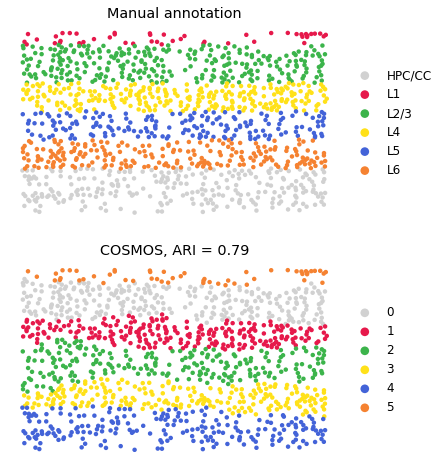

In [9]:
# Obtaining the optimal domain segmentation
df_embedding = pd.DataFrame(cosmos_ebdg.embedding)
opt_res, max_ari, opt_clusters = opt_resolution(df_embedding,list(adata.obs['LayerName']),res_s = 0.2, res_e = 1, step = 0.05,n_cluster = 6)

adata_new = adata.copy()
adata_new.obs['Cluster'] = opt_clusters
adata_new.obs["Cluster"]=adata_new.obs["Cluster"].astype('category')

matplotlib.rcParams['font.size'] = 12.0
fig, axes = plt.subplots(2, 1, figsize=(6,8))
sz = 80
plot_color=['#D1D1D1','#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', \
            '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#ffd8b1', '#800000', '#aaffc3', '#808000', '#000075', '#000000', '#808080', '#ffffff', '#fffac8']

domains="LayerName"
num_celltype=len(adata_new.obs[domains].unique())
adata_new.uns[domains+"_colors"]=list(plot_color[:num_celltype])
titles = 'Manual annotation' 
ax=sc.pl.scatter(adata_new,alpha=1,x="x_pos",y="y_pos",color=domains,title=titles ,color_map=plot_color,show=False,size=sz,ax = axes[0])
ax.axis('off')

domains="Cluster"
num_celltype=len(adata_new.obs[domains].unique())
adata_new.uns[domains+"_colors"]=list(plot_color[:num_celltype])
titles = 'COSMOS, ARI = ' + str(max_ari)
ax=sc.pl.scatter(adata_new,alpha=1,x="x_pos",y="y_pos",color=domains,title=titles ,color_map=plot_color,show=False,size=sz,ax = axes[1])
ax.axis('off')

### UMAP visualization of COSMOS integration

(-4.159879457950592,
 14.219783318042754,
 -7.029114389419556,
 15.366010332107544)

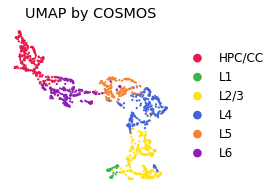

In [10]:
adata_pt = sc.AnnData(df_embedding)
umap_2d = UMAP(n_components=2, init='random', random_state=random_seed, min_dist = 0.3,n_neighbors=30,metric = "cosine")
umap_pos = umap_2d.fit_transform(df_embedding)
adata_pt.obs['x_pos'] = list(adata_new.obs['x_pos'])
adata_pt.obs['y_pos'] = list(adata_new.obs['y_pos'])
adata_pt.obs['LayerName'] = list(adata_new.obs['LayerName'])
adata_pt.obs['cosmos_umap_pos_x'] = umap_pos[:,0]
adata_pt.obs['cosmos_umap_pos_y'] = umap_pos[:,1]

matplotlib.rcParams['font.size'] = 12.0
sz = 20
fig, axes = plt.subplots(1, 1, figsize=(3,3))

plot_color=['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', \
            '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#ffd8b1', '#800000', '#aaffc3', '#808000', '#000075', '#000000', '#808080', '#ffffff', '#fffac8']

domains="LayerName"
num_celltype=len(adata_pt.obs[domains].unique())
adata_pt.uns[domains+"_colors"]=list(plot_color[:num_celltype])
titles = 'UMAP by COSMOS' 
ax=sc.pl.scatter(adata_pt,alpha=1,x="cosmos_umap_pos_x",y="cosmos_umap_pos_y",color=domains,title=titles ,color_map=plot_color,show=False,size=sz,ax = axes)
ax.axis('off')



### Pseudo-spatiotemporal map (pSM) from COSMOS integration

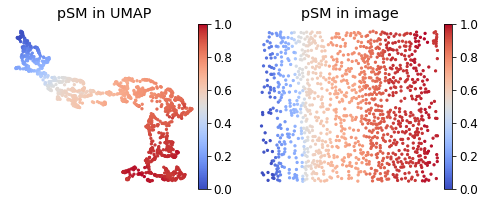

In [12]:
sc.pp.neighbors(adata_pt, n_neighbors=20, use_rep='X')
# Setting the root to be the first cell in 'HPC' cells
adata_pt.uns['iroot'] = np.flatnonzero(adata.obs['LayerName_2'] == 'HPC')[0]
# Diffusion map
sc.tl.diffmap(adata_pt)
# Diffusion pseudotime
sc.tl.dpt(adata_pt)
pSM_values = adata_pt.obs['dpt_pseudotime'].to_numpy()

matplotlib.rcParams['font.size'] = 12.0
sz = 20
fig, axes = plt.subplots(1, 2, figsize=(7,3))

x = np.array(adata_pt.obs['cosmos_umap_pos_x'])
y = np.array(adata_pt.obs['cosmos_umap_pos_y'])
ax_temp = axes[0]
im = ax_temp.scatter(x, y, s=sz, c=pSM_values, marker='.', cmap='coolwarm',alpha = 1)
ax_temp.axis('off')
ax_temp.set_title('pSM in UMAP')
fig.colorbar(im, ax = ax_temp,orientation="vertical", pad=-0.01)

x = np.array(adata_pt.obs['y_pos'])
y = np.array(adata_pt.obs['x_pos'])
ax_temp = axes[1]
im = ax_temp.scatter(x, y, s=sz, c=pSM_values, marker='.', cmap='coolwarm',alpha = 1)
ax_temp.axis('off')
ax_temp.set_title('pSM in image')
fig.colorbar(im, ax = ax_temp,orientation="vertical", pad=-0.01)

plt.tight_layout()
